# Практическое задание к уроку 2. Свёрточные нейронные сети (СНС)

Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10

Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

## Загрузка и подготовка датасета CIFAR-10

Источник - https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

In [3]:
# # Очистим значения переменных, чтобы избежать проблем с излишним потреблением памяти
# try:
#    del train_x, train_y
#    del test_x, test_y
#    print('Clear previously loaded data.')
# except:
#    pass

(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) uint8
(10000, 32, 32, 3) uint8
(50000, 1) uint8
(10000, 1) uint8


In [4]:
# train_x = train_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
# test_x = test_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

# train_y = train_y.astype(np.int32)
# test_y = test_y.astype(np.int32)

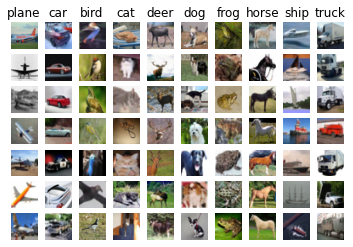

In [5]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_y == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Картинка цветная, значит указываем 3 канала
# -1 - команда вычислить сколько в тензоре находится сконкатенированных картинок

train_x = train_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

# train_y = train_y.astype(np.int32)
# test_y = test_y.astype(np.int32)

# решейпим из вертикального тензора в горизонтальный
train_y = train_y.reshape(-1).astype(np.int32)
test_y = test_y.reshape(-1).astype(np.int32)

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(50000,) int32
(10000, 32, 32, 3) float32
(10000,) int32


In [7]:
train_y

array([6, 9, 9, ..., 9, 1, 1], dtype=int32)

In [8]:
# # Для удобства преобразуем двумерные изображения в одномерные вектора fp64
# train_x = np.reshape(train_x, (train_x.shape[0], -1)).astype(np.float64)
# test_x = np.reshape(test_x, (test_x.shape[0], -1)).astype(np.float64)
# train_y = train_y.flatten()
# test_y = test_y.flatten()
# # Проверим размер полученных данных
# print('Training data shape: ', train_x.shape)
# print('Training label shape: ', train_y.shape)
# print('Test data shape: ', test_x.shape)
# print('Test label shape: ', test_y.shape)

[[[0.5125891  0.5335556  0.5198208 ]
  [0.51035565 0.5311504  0.51707786]
  [0.51392424 0.5343016  0.5199328 ]
  [0.51595825 0.535995   0.5210931 ]
  [0.51837546 0.5381541  0.5226226 ]
  [0.5209901  0.5406102  0.52463686]
  [0.52302873 0.5422941  0.526108  ]
  [0.5250642  0.54408634 0.52755016]
  [0.5273931  0.5461816  0.5294758 ]
  [0.52915096 0.5475848  0.53056467]
  [0.53033257 0.5487945  0.53142065]
  [0.53100014 0.5493823  0.532008  ]
  [0.5318505  0.5500815  0.53262335]
  [0.53190315 0.550054   0.53259194]
  [0.53190464 0.5499133  0.53247046]
  [0.53181446 0.54970396 0.5322407 ]
  [0.53149545 0.54939365 0.53170216]
  [0.53139186 0.5492686  0.5315995 ]
  [0.53134245 0.5492373  0.5316772 ]
  [0.53092    0.54887486 0.5312779 ]
  [0.52984685 0.54790294 0.53024596]
  [0.5292543  0.5475318  0.53011733]
  [0.5286725  0.5470605  0.5298459 ]
  [0.52755964 0.5462715  0.5291427 ]
  [0.52567685 0.54489666 0.52795166]
  [0.52395415 0.5434869  0.52681994]
  [0.5218709  0.5416036  0.52525735]
 

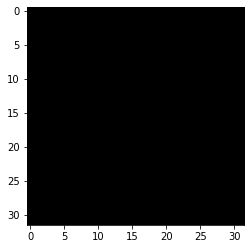

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [9]:
# Нормализуем значения яркости пикселей 
mean_image = np.mean(train_x, axis=0)
print(mean_image[:10]) 

# визуализируем среднюю яркость
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

# Вычтем средние значения яркости
train_x -= mean_image
test_x -= mean_image

# # Добавим к вектору исходных данных фиктивный признак с постоянным значением 1.
# # Этот трюк позволит избежать лишних вычислений: x @ W + b  => x' @ W'
# train_x = np.hstack([train_x, np.ones((train_x.shape[0], 1))])
# test_x = np.hstack([test_x, np.ones((test_x.shape[0], 1))])

print(train_x.shape, test_x.shape)

## Визуализация датасета CIFAR-10

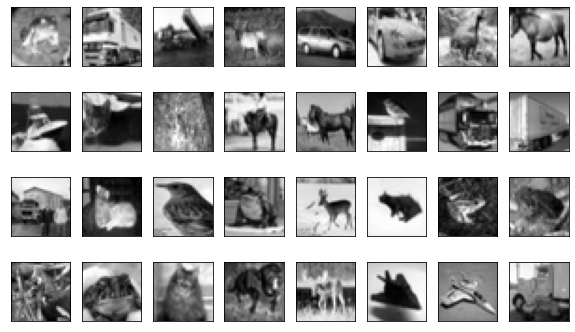

In [10]:
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

# some_samples = train_x[:32, ...]

# fig = plt.figure(figsize=(12, 7))
# for i in range(some_samples.shape[0]):
#   ax = fig.add_subplot(4, 8, i+1)
#   ax.imshow(some_samples[i, :, :, :], cmap='gray')
#   plt.title(train_y[i])
#   plt.xticks([]), plt.yticks([])
# plt.show()

# some_samples = train_x[:32, ...]

# fig = plt.figure(figsize=(14, 8))
# for j in range(some_samples.shape[0]):
#     ax = fig.add_subplot(4, 8, j+1)
#     ax.imshow(some_samples[j,:,:,:])
#     plt.xticks([]), plt.yticks([])
# plt.show()

# # classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# num_classes = len(classes)
# samples_per_class = 7
# for y, cls in enumerate(classes):
#     idxs = np.flatnonzero(train_y == y)
#     idxs = np.random.choice(idxs, samples_per_class, replace=False)
#     for i, idx in enumerate(idxs):
#         plt_idx = i * num_classes + y + 1
#         plt.subplot(samples_per_class, num_classes, plt_idx)
#         plt.imshow(train_x[idx].astype('uint8'))
#         plt.axis('off')
#         if i == 0:
#             plt.title(cls)
# plt.show()

## Создание модели CNN

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

## Подготовка к обучению

In [12]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Обучение модели

In [13]:
NUM_EPOCHS = 20

model.fit(train_x, train_y, epochs=NUM_EPOCHS)

Epoch 1/20
1563/1563 [==============================] - 13s 5ms/step - loss: 1.7850 - accuracy: 0.3634
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3947 - accuracy: 0.5047
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2342 - accuracy: 0.5634
Epoch 4/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1111 - accuracy: 0.6091
Epoch 5/20
1563/1563 [==============================] - 5s 4ms/step - loss: 1.0106 - accuracy: 0.6457
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9303 - accuracy: 0.6746
Epoch 7/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8612 - accuracy: 0.6999
Epoch 8/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8006 - accuracy: 0.7223
Epoch 9/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7443 - accuracy: 0.7425
Epoch 10/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.69

## Оценка качества модели

In [14]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 1s 3ms/step - loss: 0.9833 - accuracy: 0.7241


[0.9832608103752136, 0.7240999937057495]

## Пример инференса модели

In [15]:
sample = test_x[0, ...]
prediction = model(sample[None, ...])[0]
print(prediction)

tf.Tensor(
[2.06362805e-04 7.33816923e-05 1.93746062e-04 9.50738907e-01
 7.02946854e-05 4.26954553e-02 2.38150184e-04 1.04380234e-07
 5.78196393e-03 1.68257100e-06], shape=(10,), dtype=float32)


## Функция для инференса и отображения результата предсказания

In [16]:
def test_digit(sample):
    
    # prediction = model(sample[None, ...])[0]
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted number: {}'.format(ans))

## Запуск предсказания для изображения случайной цифры из MNIST

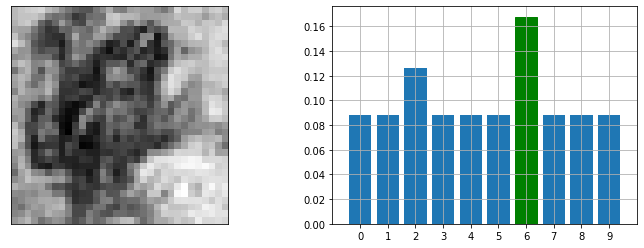

Predicted number: 6
True Answer: 6 -  frog


In [22]:
import random
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_digit(sample)

print(f'True Answer: {test_y[idx]} -  {classes[test_y[idx]]}')
# print('True Answer: {}'.format(test_y[idx]))

## Запуск предсказания на нашем изображении

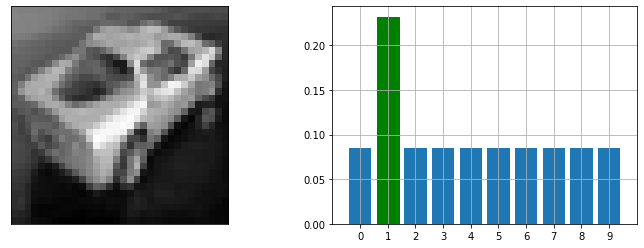

Predicted number: 1
True Answer: 1 -  car


In [18]:
import random
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_digit(sample)

print(f'True Answer: {test_y[idx]} -  {classes[test_y[idx]]}')